# Colorado Motor Vehicle Sales — Analysis & Forecast

Simple, student-style notebook. Path used for Colab CSV: `/content/colorado_motor_vehicle_sales.csv`

Sections:
- Load data
- Basic EDA
- Visualizations
- Seasonal decomposition
- Simple ARIMA forecast




In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline


In [3]:
DATA_PATH = '/content/colorado_motor_vehicle_sales.csv'

# Load dataset
df = pd.read_csv(DATA_PATH)

# Quick peek
print('Shape:', df.shape)
df.head()

Shape: (501, 4)


,year,quarter,county,sales
0,2008,1,Adams,231609000
1,2008,1,Arapahoe,550378000
2,2008,1,Boulder/Broomfield,176771000
3,2008,1,Denver,200103000
4,2008,1,Douglas,93259000


In [4]:
# Basic checks and cleaning
print(df.dtypes)
print('\nMissing values:\n', df.isnull().sum())

df = df.dropna().copy()

df['year'] = df['year'].astype(int)
df['quarter'] = df['quarter'].astype(int)
df['county'] = df['county'].astype(str)
df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0).astype(float)

df.head()

year        int64
quarter     int64
county     object
sales       int64
dtype: object

Missing values:
 year       0
quarter    0
county     0
sales      0
dtype: int64


,year,quarter,county,sales
0,2008,1,Adams,231609000.0
1,2008,1,Arapahoe,550378000.0
2,2008,1,Boulder/Broomfield,176771000.0
3,2008,1,Denver,200103000.0
4,2008,1,Douglas,93259000.0


In [5]:
df['period'] = df['year'].astype(str) + ' Q' + df['quarter'].astype(str)

df['period_dt'] = pd.PeriodIndex(year=df['year'], quarter=df['quarter'], freq='Q').to_timestamp()

quarterly = df.groupby('period_dt')['sales'].sum().rename('total_sales').reset_index()
quarterly.set_index('period_dt', inplace=True)

quarterly.head()

/tmp/ipython-input-3556863907.py:3: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df['period_dt'] = pd.PeriodIndex(year=df['year'], quarter=df['quarter'], freq='Q').to_timestamp()


,total_sales
period_dt,
2008-01-01,2.407552e+09
2008-04-01,2.427936e+09
2008-07-01,2.300541e+09
2008-10-01,1.829532e+09
2009-01-01,1.657155e+09


,total_sales
count,3.200000e+01
mean,2.756416e+09
std,6.255474e+08
min,1.657155e+09
25%,2.282590e+09
50%,2.764366e+09
75%,3.254059e+09
max,3.916440e+09


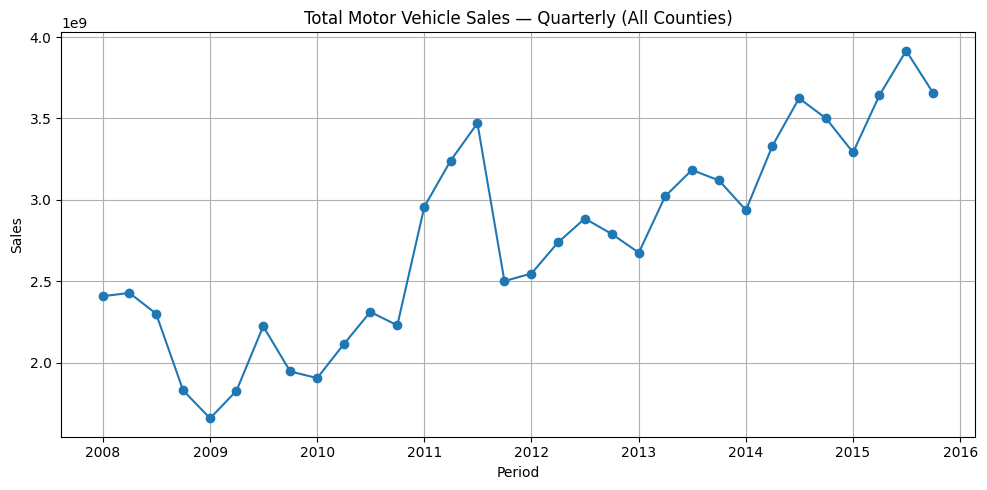

In [6]:
# Basic EDA
display(quarterly.describe())

plt.figure(figsize=(10,5))
plt.plot(quarterly.index, quarterly['total_sales'], marker='o')
plt.title('Total Motor Vehicle Sales — Quarterly (All Counties)')
plt.ylabel('Sales')
plt.xlabel('Period')
plt.grid(True)
plt.tight_layout()

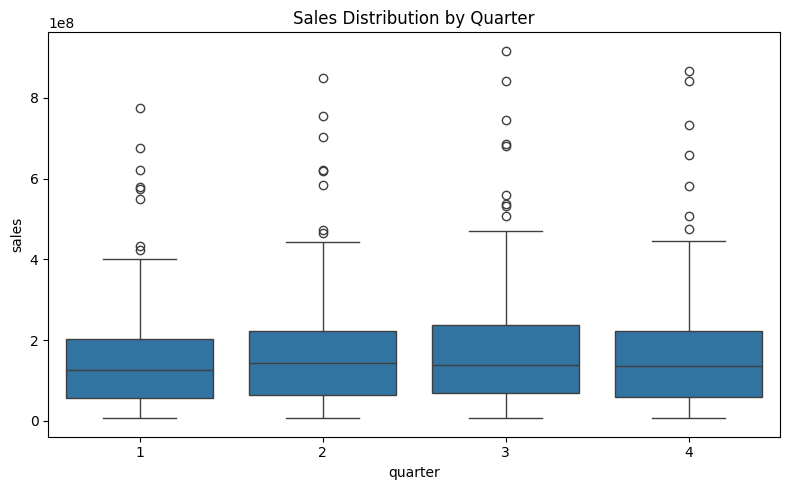

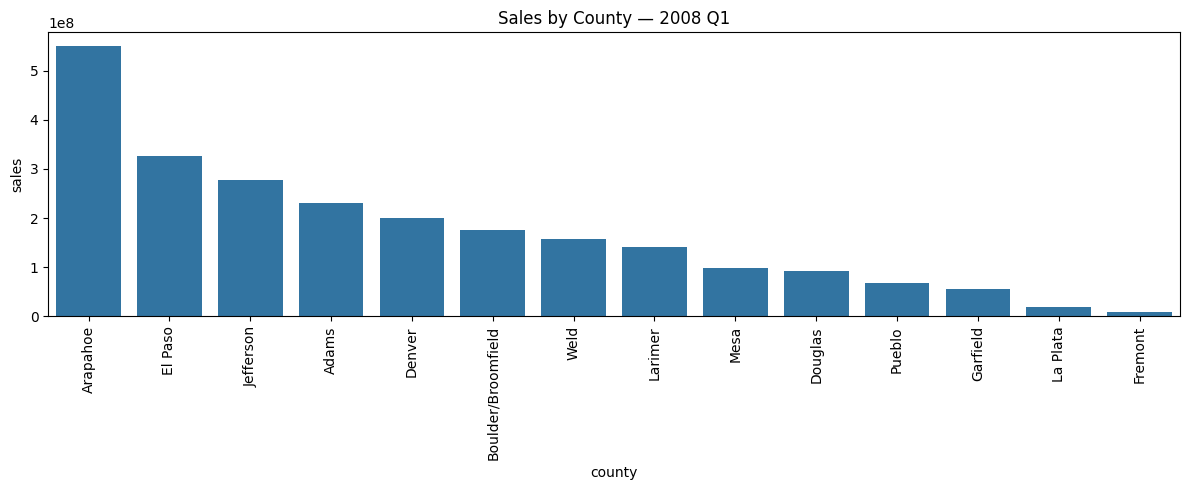

In [7]:
# Sales distribution by quarter (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='quarter', y='sales')
plt.title('Sales Distribution by Quarter')
plt.tight_layout()

sample_year = df['year'].min()
sample_q = 1
filtered = df[(df['year']==sample_year) & (df['quarter']==sample_q)].groupby('county')['sales'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=filtered, x='county', y='sales')
plt.xticks(rotation=90)
plt.title(f'Sales by County — {sample_year} Q{sample_q}')
plt.tight_layout()

In [8]:
ts = quarterly['total_sales'].asfreq('Q')

try:
    decomposition = seasonal_decompose(ts, model='additive', period=4)
    decomposition.plot()
    plt.suptitle('Seasonal Decomposition (Additive)')
    plt.tight_layout()
except Exception as e:
    print('Decomposition skipped:', e)

Decomposition skipped: This function does not handle missing values


/tmp/ipython-input-3365380053.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ts = quarterly['total_sales'].asfreq('Q')


In [24]:
df_clean = df.copy()

df_clean['year'] = df_clean['year'].astype(int)
df_clean['quarter'] = df_clean['quarter'].astype(int)
df_clean['sales'] = pd.to_numeric(df_clean['sales'], errors='coerce').fillna(0)

df_clean['period_dt'] = pd.PeriodIndex(
    year=df_clean['year'],
    quarter=df_clean['quarter'],
    freq='Q'
).to_timestamp()

quarterly = (
    df_clean.groupby('period_dt')['sales']
    .sum()
    .sort_index()
)

print("Quarterly length:", len(quarterly))
print(quarterly.head())


ts = quarterly.copy()

try:
    ts = ts.asfreq("QE")
except:
    ts = ts.asfreq("Q")

print("Final ts length:", len(ts))
print(ts.head())


Quarterly length: 32
period_dt
2008-01-01    2.407552e+09
2008-04-01    2.427936e+09
2008-07-01    2.300541e+09
2008-10-01    1.829532e+09
2009-01-01    1.657155e+09
Name: sales, dtype: float64
Final ts length: 31
period_dt
2008-03-31   NaN
2008-06-30   NaN
2008-09-30   NaN
2008-12-31   NaN
2009-03-31   NaN
Freq: QE-DEC, Name: sales, dtype: float64


In [20]:
import pandas as pd
import numpy as np

df_clean = df.copy()
df_clean['year'] = df_clean['year'].astype(int)
df_clean['quarter'] = df_clean['quarter'].astype(int)
df_clean['sales'] = pd.to_numeric(df_clean['sales'], errors='coerce').fillna(0)

df_clean['period_dt_end'] = pd.PeriodIndex(
    year=df_clean['year'],
    quarter=df_clean['quarter'],
    freq='Q'
).to_timestamp(how='end')

quarterly = df_clean.groupby('period_dt_end')['sales'].sum().sort_index()

print("Quarterly length:", len(quarterly))
print(quarterly.head())

ts = quarterly.copy()
ts = ts.asfreq('QE')

print("Final ts length:", len(ts))
print(ts.head())

Quarterly length: 32
period_dt_end
2008-03-31 23:59:59.999999999    2.407552e+09
2008-06-30 23:59:59.999999999    2.427936e+09
2008-09-30 23:59:59.999999999    2.300541e+09
2008-12-31 23:59:59.999999999    1.829532e+09
2009-03-31 23:59:59.999999999    1.657155e+09
Name: sales, dtype: float64
Final ts length: 32
period_dt_end
2008-03-31 23:59:59.999999999    2.407552e+09
2008-06-30 23:59:59.999999999    2.427936e+09
2008-09-30 23:59:59.999999999    2.300541e+09
2008-12-31 23:59:59.999999999    1.829532e+09
2009-03-31 23:59:59.999999999    1.657155e+09
Freq: QE-DEC, Name: sales, dtype: float64


In [23]:
# Small RandomForest example using simple features: year, quarter, county (encoded)
df_ml = df.copy()
df_ml['county_code'] = df_ml['county'].astype('category').cat.codes

X = df_ml[['year','quarter','county_code']]
y = df_ml['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RandomForest RMSE: {rmse_rf:.2f}')

RandomForest RMSE: 20402876.97


## Notes

- This notebook is intentionally simple and educational.

